In [1]:
%load_ext autoreload
%autoreload 2
# chdir to parent directory of current notebook
import sys
sys.path.append('../')

import pandas as pd
from khronos import transform
import jax
import jax.numpy as jnp
import flax.linen as nn
import seaborn as sns


In [2]:
import os
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
ARTIFACT_DIR = f'{BASE_DIR}/artifacts'
INPUT_PATH = f'{ARTIFACT_DIR}/data/input.csv'


In [16]:
dataset = pd.read_csv(os.path.join(BASE_DIR, './artifacts/data/raw.csv'), index_col=0, header=[0, 1]).sort_index(axis=1)

In [18]:
flat_df = transform.flatten_dataset(dataset)
df_with_index_as_datetime = transform.convert_index_to_datetime(flat_df)
df_with_timestamp = transform.add_timestamp_in_seconds_as_raw_input(df_with_index_as_datetime)
df_with_timestamp.head()

,close,high,low,open,volume,ticker,timestamp_in_seconds
timestamp,,,,,,,
2017-09-11 09:30:00,44.01,44.05,44.01,44.01,39049.0,AAL,1505122200
2017-09-11 09:30:00,160.57,160.62,160.50,160.50,407091.0,AAPL,1505122200
2017-09-11 09:30:00,84.53,84.53,84.46,84.46,200.0,ABBV,1505122200
2017-09-11 09:30:00,83.24,83.33,83.24,83.33,13302.0,ABC,1505122200
2017-09-11 09:30:00,134.00,134.62,133.61,134.62,23371.0,ACN,1505122200


In [19]:
# store artifact as input.csv
df_with_timestamp.to_csv(os.path.join(BASE_DIR, './artifacts/data/input.csv'))

In [32]:
raw_input_df = pd.read_csv(os.path.join(BASE_DIR, './artifacts/data/input.csv'), index_col=0, parse_dates=True)

In [4]:
from khronos.task import PipelineConfig

p_config = PipelineConfig(
    artifact_dir='./artifacts',
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
)

In [5]:
from khronos.data_loader import RawInputArtifact

example_gen = RawInputArtifact(INPUT_PATH, ARTIFACT_DIR, p_config.train_split, p_config.val_split, p_config.test_split)

In [6]:
example_gen.run()

[{'name': 'train__split',
  'path': '/Users/stefruinard/Library/CloudStorage/OneDrive-Microsoft/Documents/work/projects/202302 - Applications and Machine Learning/azure_staff_engineer/src/khronos/artifacts/example_gen/train.csv'},
 {'name': 'val__split',
  'path': '/Users/stefruinard/Library/CloudStorage/OneDrive-Microsoft/Documents/work/projects/202302 - Applications and Machine Learning/azure_staff_engineer/src/khronos/artifacts/example_gen/val.csv'},
 {'name': 'test__split',
  'path': '/Users/stefruinard/Library/CloudStorage/OneDrive-Microsoft/Documents/work/projects/202302 - Applications and Machine Learning/azure_staff_engineer/src/khronos/artifacts/example_gen/test.csv'}]

## Feature Engineering

predict end of day price is probably not a good idea, because it is too noisy. Instead, we can predict the price change from the previous day. This is a much easier task, and we can use the same model to predict the price change for the next day.
In addition, to simplify the problem by making it a categorical problem and have the model predict the price change as a category. We can use the following categories:

0 = price change < -20%
1 = -20% <= price change < -10%
2 = -10% <= price change < -5%
3 = -5% <= price change < -2%
4 = -2% <= price change < -1%
5 = -1% <= price change < 0%
6 = 0% <= price change < 1%
7 = 1% <= price change < 2%
8 = 2% <= price change < 5%
9 = 5% <= price change < 10%
10 = 10% <= price change < 20%
11 = 20% <= price change


In [7]:
train_df, val_df, test_df = example_gen.load_input_artifacts()

In [8]:
# verify no look-ahead bias between train, val, test dataframes using the index

has_lookahead_bias = False
datasets = [train_df, val_df, test_df]
for i, (flag, dataset) in enumerate(zip(['train', 'val', 'test'], datasets)):
    if i == 0:
        continue
    if dataset.index[0] < datasets[i-1].index[-1]:
        print(f'dataset.index[0]: {dataset.index[0]}')
        print(f'datasets[i-1].index[-1]: {datasets[i-1].index[-1]}')
        has_lookahead_bias = True
        break
print(f'has_lookahead_bias: {has_lookahead_bias}')

has_lookahead_bias: False


In [9]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
close,16304528.0,1.005783e+02,1.242623e+02,3.420000e+00,4.564000e+01,7.316000e+01,1.173100e+02,1.961090e+03
high,16304528.0,1.006067e+02,1.242943e+02,3.425000e+00,4.566000e+01,7.318000e+01,1.173400e+02,1.961450e+03
low,16304528.0,1.005503e+02,1.242312e+02,3.410000e+00,4.563000e+01,7.314000e+01,1.172800e+02,1.961090e+03
open,16304528.0,1.005786e+02,1.242630e+02,3.420000e+00,4.564000e+01,7.316000e+01,1.173100e+02,1.961450e+03
volume,16304528.0,8.796356e+03,3.999298e+04,1.000000e+02,9.000000e+02,2.579000e+03,6.790000e+03,2.314586e+07
timestamp_in_seconds,16304528.0,1.510470e+09,3.240783e+06,1.505122e+09,1.507716e+09,1.510307e+09,1.513248e+09,1.516277e+09


In [10]:
# fit train_df on RobustScaler

columns_to_scale = ['open', 'high', 'low', 'close', 'volume']
# compute max and min for each column
max_values = train_df[columns_to_scale].max()
min_values = train_df[columns_to_scale].min()


In [11]:
maxs = jnp.array(max_values)
mins = jnp.array(min_values)


In [31]:
def normalize(x, mins, maxs):
    return (x - mins) / (maxs - mins)


def standardize(x, means, stds):
    return (x - means) / stds

In [14]:
batch = jnp.array([
    [[1, 2, 3], [4, 5, 6]],
    [[7, 8, 9], [10, 11, 12]]
])



mins, maxs = jnp.array([1, 1, 1]), jnp.array([12, 12, 12])
normalize(batch, mins, maxs)

Array([[[0.        , 0.09090909, 0.18181819],
        [0.27272728, 0.36363637, 0.45454547]],

       [[0.54545456, 0.6363636 , 0.72727275],
        [0.8181818 , 0.90909094, 1.        ]]], dtype=float32)

In [15]:
train_df_grouped_per_ticker = transform.to_multi_index_df(train_df)

In [16]:
train_df_grouped_per_ticker.head()

close   high      low     open   volume  \
ticker timestamp                                                      
A      2017-09-11 09:31:00  65.46  65.50  65.4100  65.5000  29852.0   
       2017-09-11 09:32:00  65.66  65.66  65.4604  65.4604   3435.0   
       2017-09-11 09:33:00  65.69  65.70  65.6200  65.6700    700.0   
       2017-09-11 09:34:00  65.88  65.88  65.6800  65.6900   2814.0   
       2017-09-11 09:35:00  65.83  65.90  65.7700  65.8100   1300.0   

                            timestamp_in_seconds  
ticker timestamp                                  
A      2017-09-11 09:31:00            1505122260  
       2017-09-11 09:32:00            1505122320  
       2017-09-11 09:33:00            1505122380  
       2017-09-11 09:34:00            1505122440  
       2017-09-11 09:35:00            1505122500

In [17]:
# lets work with MSFT

msft_df = train_df_grouped_per_ticker.loc['MSFT']

In [18]:
msft_df.head()
# plot high and low

,close,high,low,open,volume,timestamp_in_seconds
timestamp,,,,,,
2017-09-11 09:30:00,74.45,74.5396,74.310,74.31,286599.0,1505122200
2017-09-11 09:31:00,74.52,74.5400,74.400,74.46,101285.0,1505122260
2017-09-11 09:32:00,74.55,74.6490,74.510,74.53,109611.0,1505122320
2017-09-11 09:33:00,74.62,74.7000,74.525,74.55,112117.0,1505122380
2017-09-11 09:34:00,74.63,74.6600,74.610,74.62,65501.0,1505122440


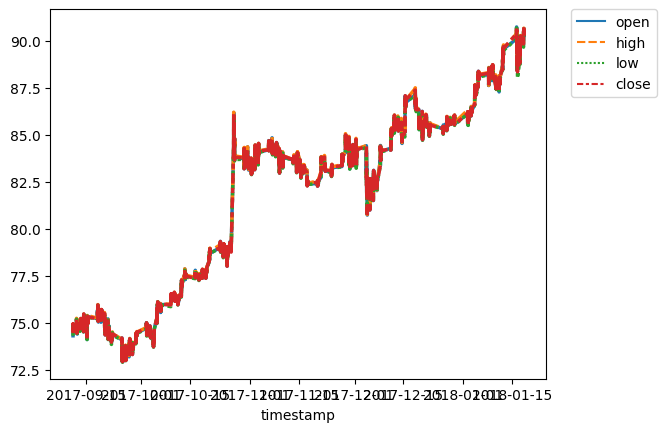

In [19]:
# plost open high low close

# msft_df[['open', 'high', 'low', 'close']].plot(figsize=(20, 10), title='MSFT')
# now use seaborn to make it interactive
import seaborn as sns
fig = sns.lineplot(data=msft_df[['open', 'high', 'low', 'close']], palette="tab10", linewidth=2.5)
# add interactive legend
fig.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)






In [32]:
# create hour of day, time of day signals features
n_seconds_in_a_day = 24 * 60 * 60
n_seconds_in_an_hour = 60 * 60
n_seconds_in_a_year = 365 * n_seconds_in_a_day

def sin_signal(timestamp_in_seconds: jnp.ndarray, n_seconds_divider: int):
    return jnp.sin(2 * jnp.pi * timestamp_in_seconds / n_seconds_divider)

def cos_signal(timestamp_in_seconds: jnp.ndarray, n_seconds_divider: int):
    return jnp.cos(2 * jnp.pi * timestamp_in_seconds / n_seconds_divider)

timestamp_in_seconds = jnp.array(msft_df['timestamp_in_seconds'].values, dtype=jnp.float32)

hourly_signals = jnp.stack([
    sin_signal(timestamp_in_seconds, n_seconds_in_an_hour),
    cos_signal(timestamp_in_seconds, n_seconds_in_an_hour),
], axis=1)

daily_signals = jnp.stack([
    sin_signal(timestamp_in_seconds, n_seconds_in_a_day),
    cos_signal(timestamp_in_seconds, n_seconds_in_a_day),
], axis=1)

yearly_signals = jnp.stack([
    sin_signal(timestamp_in_seconds, n_seconds_in_a_year),
    cos_signal(timestamp_in_seconds, n_seconds_in_a_year),
], axis=1)




In [33]:
all_timesignals_stacked = jnp.hstack(
    [hourly_signals, daily_signals, yearly_signals]
)

all_timesignals_stacked.shape

(34517, 6)

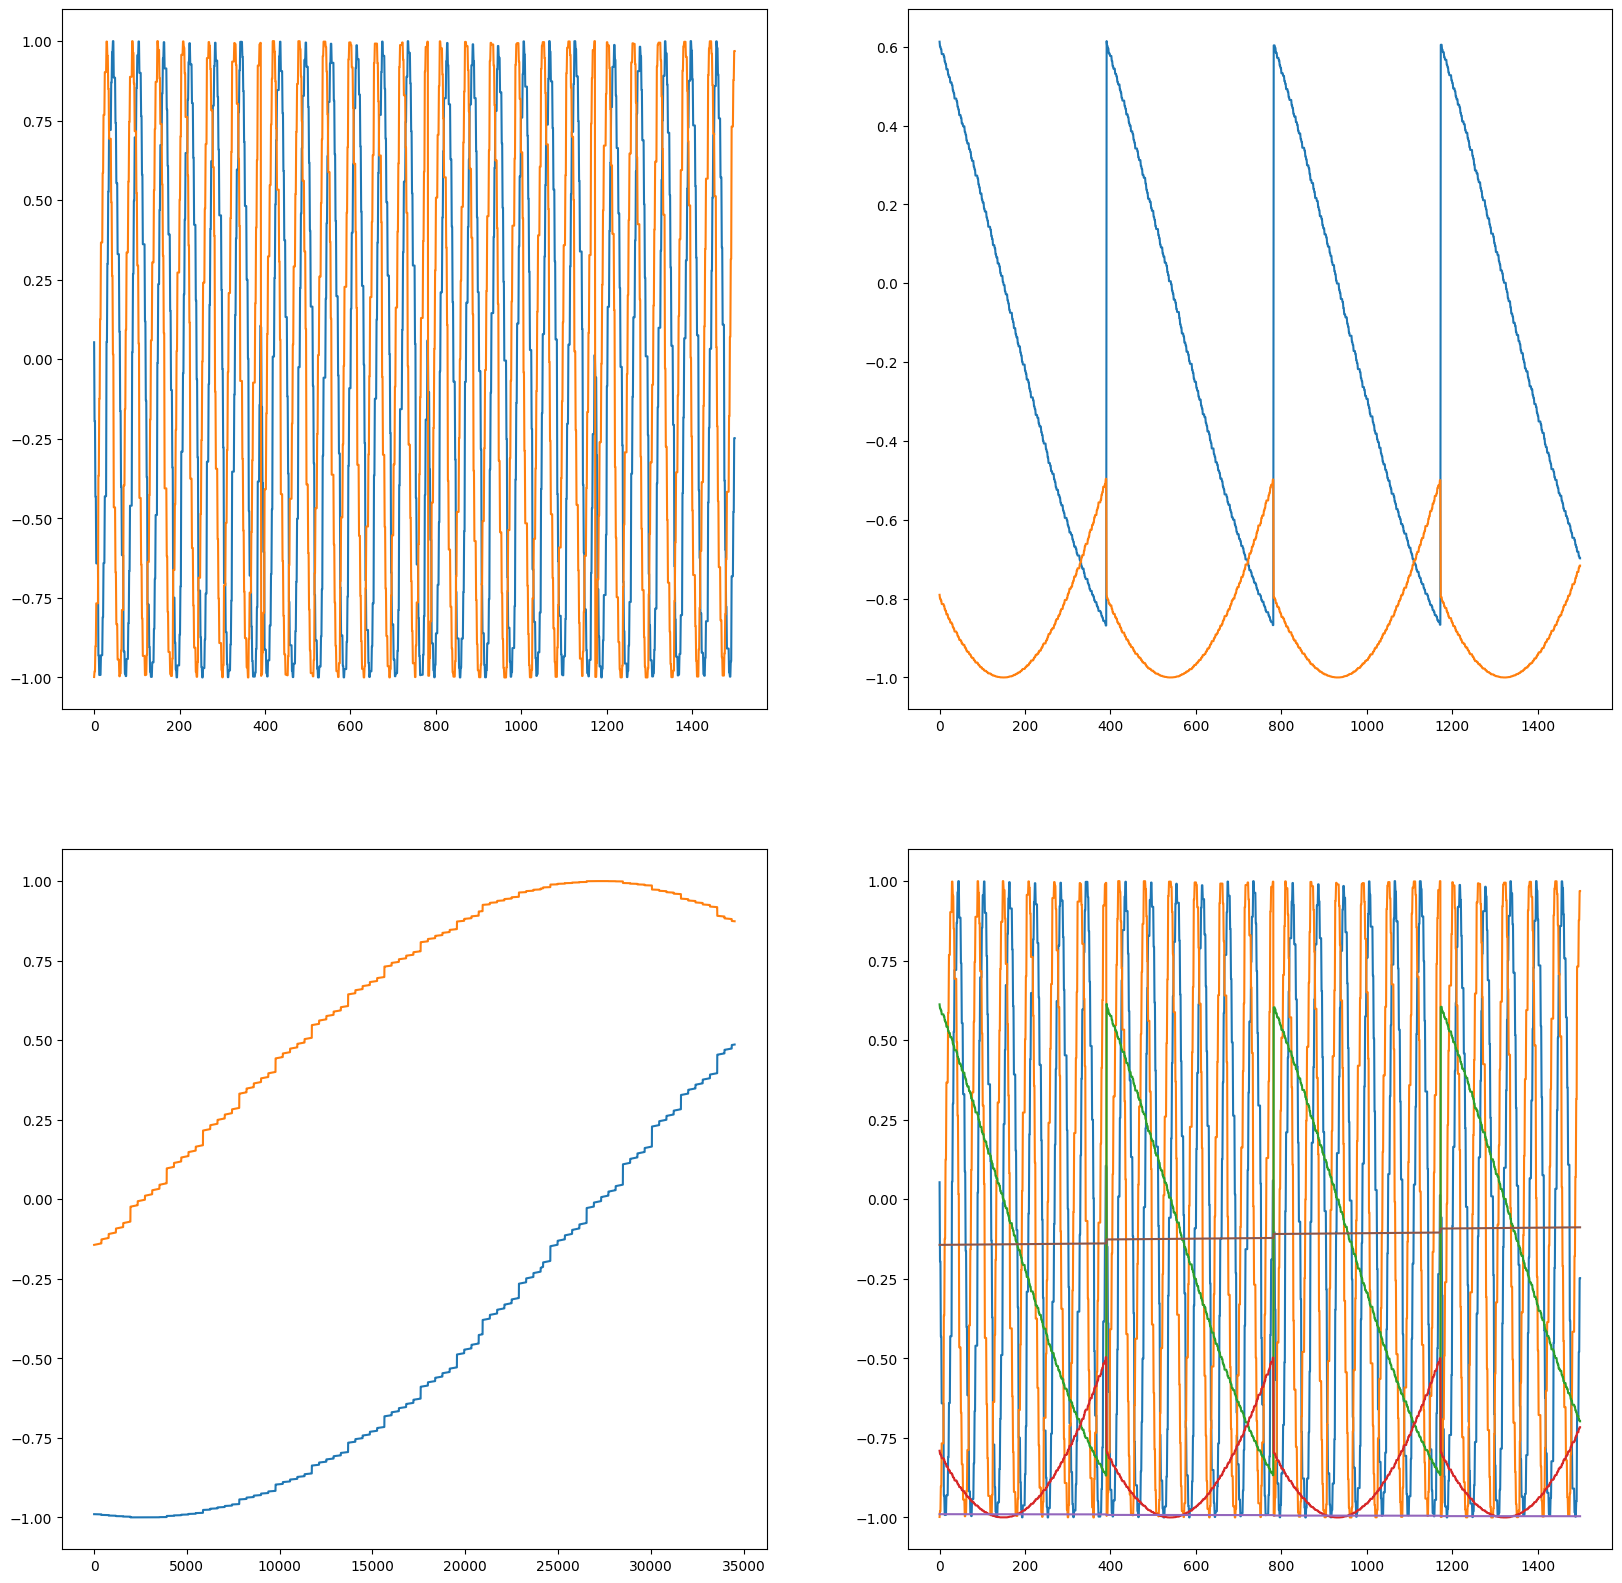

In [34]:
# create a figure having four subplots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

show_first_n_rows = 1500
# the first three figures are the indepenedent time series 
axes[0, 0].plot(hourly_signals[:show_first_n_rows])
axes[0, 1].plot(daily_signals[:show_first_n_rows])
axes[1, 0].plot(yearly_signals)

# the last figure is the stacked time series
axes[1, 1].plot(all_timesignals_stacked[:show_first_n_rows])
plt.show()

In [39]:
# train_df only numerical features
import numpy as np 
train_df_numerical = train_df[['open', 'high', 'low', 'close', 'volume', 'timestamp_in_seconds']]
train_df_numerical['log_scale_volume'] = np.log(train_df_numerical['volume'])

timestamp_in_sec = train_df_numerical['timestamp_in_seconds'].values
# add hourly, daily and yearly sin and cos features
hourly_sin_signal = sin_signal(timestamp_in_sec, n_seconds_in_an_hour)
hourly_cos_signal = cos_signal(timestamp_in_sec, n_seconds_in_an_hour)
daily_sin_signal = sin_signal(timestamp_in_sec, n_seconds_in_a_day)
daily_cos_signal = cos_signal(timestamp_in_sec, n_seconds_in_a_day)
yearly_sin_signal = sin_signal(timestamp_in_sec, n_seconds_in_a_year)
yearly_cos_signal = cos_signal(timestamp_in_sec, n_seconds_in_a_year)


# drop engineered raw input columns
train_df_numerical = train_df_numerical.drop(columns=['volume', 'timestamp_in_seconds'])


train_df_std = (train_df_numerical - train_df_numerical.mean()) / train_df_numerical.std()



In [40]:

# add cos and sin signals
train_df_std['hourly_sin_signal'] = hourly_sin_signal
train_df_std['hourly_cos_signal'] = hourly_cos_signal
train_df_std['daily_sin_signal'] = daily_sin_signal
train_df_std['daily_cos_signal'] = daily_cos_signal
train_df_std['yearly_sin_signal'] = yearly_sin_signal
train_df_std['yearly_cos_signal'] = yearly_cos_signal

In [41]:
train_df_std = train_df_std.melt(var_name='Column', value_name='Normalized')
train_df_std

,Column,Normalized
0,open,-0.455233
1,open,0.482214
2,open,-0.129714
3,open,-0.138807
4,open,0.273946
...,...,...
179349803,yearly_cos_signal,0.873765
179349804,yearly_cos_signal,0.873765
179349805,yearly_cos_signal,0.873765
179349806,yearly_cos_signal,0.873765


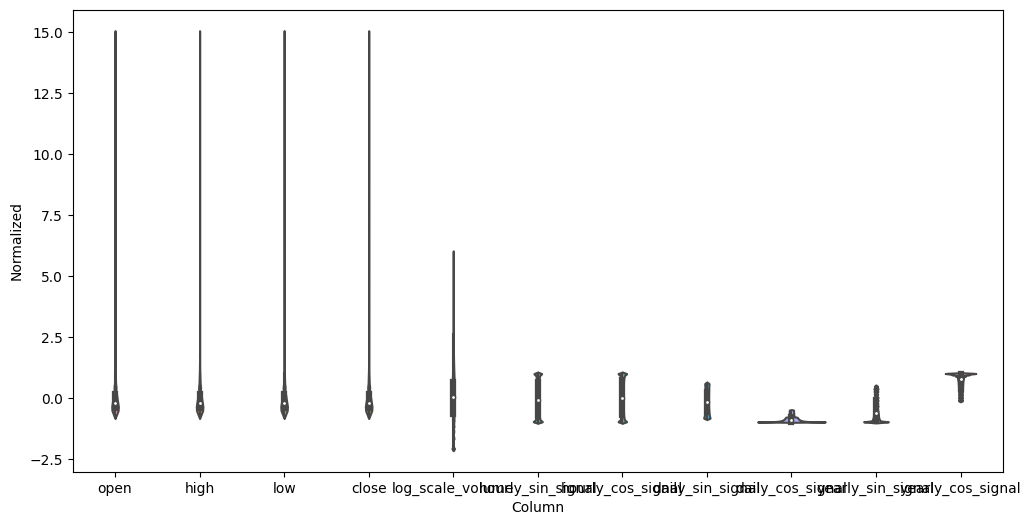

In [42]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=train_df_std)
# _ = ax.set_xticklabels(train_df_std.keys(), rotation=90)